In [1]:
# Seeding ramdom functions
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

In [2]:
pip install keras-tuner 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 7.4 MB/s 
     |████████████████████████████████| 1.6 MB 38.5 MB/s 


In [3]:
# Importing Libraries
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from keras.applications import ResNet50
from keras.optimizers import Adam
import cv2
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import applications
from keras.applications import Xception
from keras.models import Model
from keras import optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [4]:
# Loading Training and testing data
train_csv=pd.read_csv("/content/train.csv")
test_csv=pd.read_csv("/content/test.csv")

In [5]:
train_csv.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


In [6]:
#Printing number of instances in Training and testing data
# Originally, there were 364 examples but due to class-imbalance, we have added reqd images with the other training images.
print("Total number of instances in training data is : {} ".format(train_csv.shape[0]))
print("Total number of instances in testing data is : {} ".format(test_csv.shape[0]))

Total number of instances in training data is : 364 
Total number of instances in testing data is : 156 


In [7]:
#Determining unique data categories in target label
# Earlier, Manipuri had 36 samples which accounted for class-imbalanceness.
train_csv['target'].value_counts()

mohiniyattam     50
odissi           49
bharatanatyam    47
kathakali        47
kuchipudi        46
sattriya         45
kathak           44
manipuri         36
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


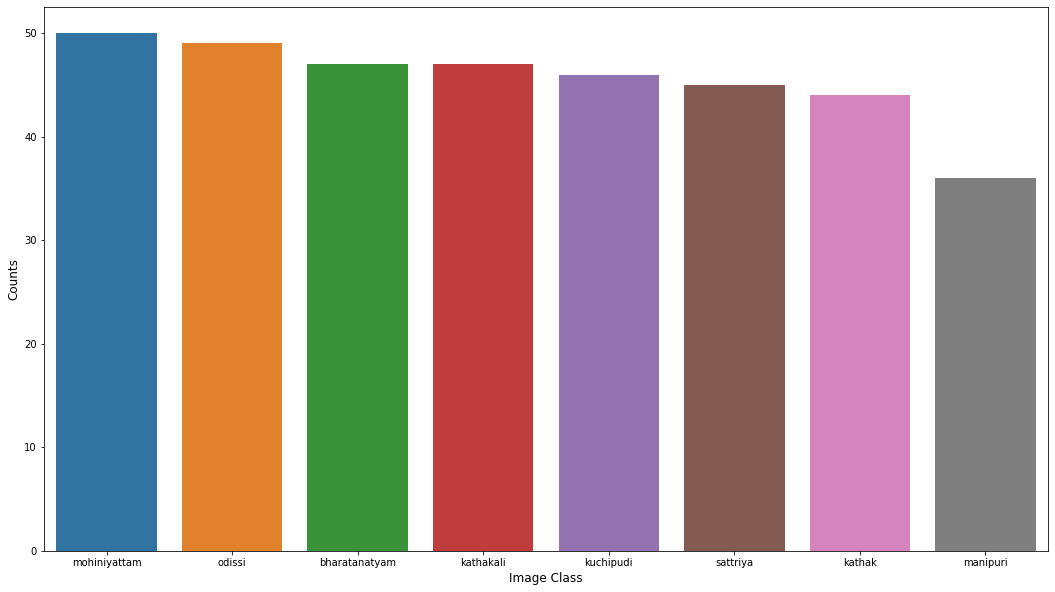

In [8]:
# Visualizing samples in different categories in training data
labels_count = train_csv['target'].value_counts()
plt.figure(figsize=(18,10))
sns.barplot(labels_count.index,labels_count.values)
plt.xticks(rotation='horizontal')
plt.xlabel('Image Class',fontsize=12)
plt.ylabel('Counts',fontsize=12)
plt.show()

In [9]:
TRAIN_PATH = "/content/train/"
TEST_PATH = "/content/test/"

In [10]:
# Reading image
IMAGE_SIZE = 224
def read_img(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
  return img

In [11]:

# Calling the read_img function
train_img = []
for img_name in tqdm(train_csv['Image'].values):
  train_img.append(read_img(TRAIN_PATH+img_name))

100%|██████████| 364/364 [00:02<00:00, 133.95it/s]


In [12]:
# Converting it into float arrays and normalizing it
X = np.array(train_img,np.float32)/255
print(X.shape)

(364, 224, 224, 3)


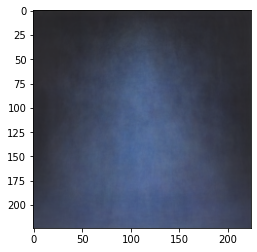

In [13]:
#Calculating the mean of the image
mean_img = np.mean(X,axis=0)
plt.imshow(mean_img)

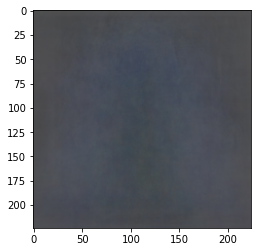

In [14]:
# Caculating the std 
std_img = np.std(X,axis=0)
plt.imshow(std_img)

In [15]:
# Normalizing the image data X
X = (X-mean_img) / std_img
X.shape

(364, 224, 224, 3)

In [16]:
# Assigning output labels unique numbers
label_list = train_csv["target"].tolist()
label_numeric = {k:v for v,k in enumerate(set(label_list))}
y = [label_numeric[k] for k in label_list]
y = np.array(y)

In [17]:
# Encoding y outputs
y = to_categorical(y,num_classes=8)

In [18]:
print(y.shape)

(364, 8)


In [19]:
# Splitting the data into train and validation set
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)

In [20]:
# Defining base model
base_model = applications.Xception(include_top=False,weights='imagenet',input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

83683744/83683744 [==============================] - 0s 0us/step


In [21]:
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dropout(0.5))
add_model.add(Dense(512,activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(Dense(y.shape[1],activation='softmax'))
model = Model(inputs=base_model.input,outputs = add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                )                                                                 
                                                                                                  
 block1_conv2_bn (BatchNormaliz  (None, 109, 109, 64  256        ['block1_conv2[0][0]']           
 ation)                         )                                                                 
                                                                                                  
 block1_conv2_act (Activation)  (None, 109, 109, 64  0           ['block1_conv2_bn[0][0]']        
                                )                                                                 
                                                                                                  
 block2_sepconv1 (SeparableConv  (None, 109, 109, 12  8768       ['block1_conv2_act[0][0]']       
 2D)                            8)                                                                
          

In [22]:
# Data Augumentation
train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1, 
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
train_datagen.fit(x_train)

In [ ]:
# Training of Model
batch_size = 4
epochs=60
history = model.fit(train_datagen.flow(x_train,y_train,batch_size=batch_size),validation_data=(x_valid,y_valid),steps_per_epoch=len(x_train)//batch_size,epochs=epochs)


Epoch 1/60
72/72 [==============================] - 370s 5s/step - loss: 2.3650 - accuracy: 0.1045 - val_loss: 1.8073 - val_accuracy: 0.3288
Epoch 2/60
72/72 [==============================] - 315s 4s/step - loss: 2.0919 - accuracy: 0.2300 - val_loss: 1.7568 - val_accuracy: 0.3425
Epoch 3/60
72/72 [==============================] - 313s 4s/step - loss: 1.9021 - accuracy: 0.2718 - val_loss: 1.6341 - val_accuracy: 0.4658
Epoch 4/60
72/72 [==============================] - 321s 4s/step - loss: 1.8464 - accuracy: 0.3693 - val_loss: 1.5185 - val_accuracy: 0.5616
Epoch 5/60
72/72 [==============================] - 317s 4s/step - loss: 1.8082 - accuracy: 0.3484 - val_loss: 1.4534 - val_accuracy: 0.5205
Epoch 6/60
72/72 [==============================] - 318s 4s/step - loss: 1.6378 - accuracy: 0.4216 - val_loss: 1.3821 - val_accuracy: 0.4932
Epoch 7/60
72/72 [==============================] - 322s 4s/step - loss: 1.4487 - accuracy: 0.4808 - val_loss: 1.2777 - val_accuracy: 0.5479
Epoch 8/60
72

In [ ]:
# Hyper-parameter tuning CNN model using Random Search CV
base_model = Xception(include_top=False,weights='imagenet',input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))
def build(hp):

  add_model = Sequential()
  add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
  add_model.add(Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.4,
                max_value=0.55,
                default=0.4,
                step=0.05,)))
  add_model.add(Dense(
          units=hp.Int(
                    'units',
                    min_value=128,
                    max_value=512,
                    step=32,
                    default=128),activation='relu'))
  add_model.add(Dropout(rate=hp.Float('dropout_2',
                min_value=0.4,
                max_value=0.55,
                default=0.4,
                step=0.05)))
  add_model.add(Dense(8,activation='softmax'))
  model = Model(inputs=base_model.input,outputs = add_model(base_model.output))
  model.compile(loss='categorical_crossentropy', optimizer=
                    optimizers.Adam(
                    hp.Float(
                    'learning_rate',
                    min_value=1e-5,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ), metrics=['accuracy'])
  return model
 
SEED=1
tuner = RandomSearch(
    build,
    objective='val_accuracy',
    seed=SEED,
    max_trials=10,
    executions_per_trial=1,
    directory='random_search',
    project_name='CNN'
)
train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1, 
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
train_datagen.fit(x_train)
history = tuner.search(train_datagen.flow(x_train, y_train,batch_size=4), epochs=90, validation_data = (x_valid,y_valid), steps_per_epoch=len(x_train)//4,verbose=1)


In [ ]:
# Summary of the Hyper-Parameter Tuning Results
tuner.results_summary()

In [ ]:
#Extracting the best CNN model
best_model = tuner.get_best_models(num_models=1)[0] # Best_val accuracy is 86.84%

In [ ]:
# loss curves of trained Model
plt.figure(figsize=[10, 6])
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training loss', 'Validation loss'], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)
plt.show()

# Accuracy curves of the trained Model
plt.figure(figsize=[15, 10])
plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)
plt.show()

In [ ]:
## Calling the read_img function
test_img = []
for img_name in tqdm(test_csv['Image'].values):
  test_img.append(read_img(TEST_PATH+img_name))

In [ ]:
# Converting it into float arrays and normalizing it
X_test = np.array(test_img,np.float32)/255
mean_img = np.mean(X_test,axis=0)
std_img = np.std(X_test,axis=0)
X_test = (X_test-mean_img) / std_img

In [ ]:
#Predictions on testing data
#predictions = model.predict(X_test) # W/o.r.t Hyper-parameter modelling
predictions = best_model.predict(X_test) # W.r.t Hyper-parameter modelling

In [ ]:
#Unrolling Predictions
predictions = np.argmax(predictions,axis=1)
rev_y = {v:k for k,v in label_numeric.items()}
pred_labels = [rev_y[k] for k in predictions]

In [ ]:
# Final Predictions
output = pd.DataFrame({"Image":test_csv.Image,"target":pred_labels})
filename = "Identify_dance_forms.csv"
output.to_csv(filename,index=False)
output.head()